Problem 11: Lennard-Jones Fluid

Study the thermal behavior of a system of interacting particles by Molecular Dynamics simulations. Consider N particles of mass m, which interact via the pairwise Lennard-Jones potential
$$V_{LJ}(r) = 4 \epsilon [(\frac{\sigma}{r})^{12}-(\frac{\sigma}{r})^6]$$
with a cut-off radius of 2.5 σ, where r is the particle distance. Choose σ = ϵ = 1, which corresponds to measuring lengths and energies in these units. For simplicity, consider a system in two dimensions.

(a) As an initial state, construct a hexagonal crystal of particles with periodic boundary conditions, such that each particle has six neighbors. The total number of particles should be at least 100. Choose the same neighbor distance for all particles, such that the area density, ρσ2 , is 0.8.

(b) For the initial velocities vi
, choose a random direction for each particle. The magnitude of
the velocity can either be drawn from a Maxwell-Boltzmann distribution with temperature T, or taken to be identical for all particles such that $\frac{1}{2} m <v^2> = k_B T$.

(c) Use the velocity-Verlet algorithm to integrate the equations of motion. Investigate the
behavior of the system as for values of kBT/ϵ in the range 0.4 ≤ kBT/ϵ ≤ 0.6.

(d) Calculate the temperature and plot it as a function of time.

(e) Calculate the pressure, and the diffusion coefficient. Plot the pressure and the diffusion coefficient as a function of the actual temperature

(f) Implement Euler algorithm and check the differences.

(g) Calculate the pressure as a function of density ρσ2 in the regime 0.1 ≤ ρσ2 ≤ 0.8 at the actual temperature kBT/ϵ ≃ 0.45. Note that the actual temperature can be adjusted by a “one-time” rescaling of particle velocities

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.optimize import curve_fit
import numpy as np

# Constants
N = 100  # Number of particles
L = np.sqrt(N / 0.8)  # Box length
rc = 2.5  # Cutoff radius
dt = 0.01  # Time step

# Initialization
positions = np.zeros((N, 2))  # Particle positions
velocities = np.zeros((N, 2))  # Particle velocities
forces = np.zeros((N, 2))  # Particle forces

# (a) Construct hexagonal crystal
nx = int(np.sqrt(N))
ny = int(N / nx)
delta_x = L / (nx + 0.5)
delta_y = L / (ny + 0.5)
count = 0
for i in range(nx):
    for j in range(ny):
        x = (i + 0.5 * (j % 2)) * delta_x  # Shift every other row
        y = j * delta_y
        positions[count, :] = [x, y]
        count += 1
positions_ini = np.copy(positions)
# (b) Assign random velocities from Maxwell-Boltzmann distribution
T = 0.4  # Temperature
velocities = np.random.randn(N, 2) * np.sqrt(T)

# Helper functions
def lj_force(r):
    """Lennard-Jones force between two particles."""
    sr6 = (1 / r) ** 6
    sr12 = sr6 ** 2
    return 24 * (2 * sr12 - sr6) / r

def compute_forces():
    """Compute forces on particles."""
    forces = np.zeros((N, 2))
    pressure_x, pressure_y = 0,0
    for i in range(N):
        for j in range(i + 1, N):
            dx = positions[i, 0] - positions[j, 0]
            dy = positions[i, 1] - positions[j, 1]
            dx -= L * np.round(dx / L)  # Minimum image convention
            dy -= L * np.round(dy / L)  # Minimum image convention
            r = np.sqrt(dx**2 + dy**2)
            if r < rc:
                f = lj_force(r)
                pressure_x -= f * dx * dx / r
                pressure_y -= f * dy * dy / r
                forces[i, 0] += f * dx / r
                forces[i, 1] += f * dy / r
                forces[j, 0] -= f * dx / r
                forces[j, 1] -= f * dy / r
    pressure = (pressure_x+pressure_y)/2
    return forces,pressure


# (c) Velocity-Verlet integration
def velocity_verlet_step():
    global positions, velocities, forces
    forces,pressure = compute_forces()
    positions += velocities * dt + 0.5 * forces * dt**2
    positions = np.mod(positions, L)  # Apply periodic boundary conditions
    forces_new,pressure = compute_forces()
    velocities += 0.5 * (forces + forces_new) * dt

def Euler_step():
    global positions, velocities, forces
    forces,pressure = compute_forces()
    positions += velocities * dt + 0.5 * forces * dt**2
    positions = np.mod(positions, L)  # Apply periodic boundary conditions
    velocities +=  forces * dt
    
# (d) Calculate temperature
def calculate_temperature():
    return np.mean(np.sum(velocities**2, axis=1)) / 2



Text(0.5, 1.0, 'hexagonal lattice crystal')

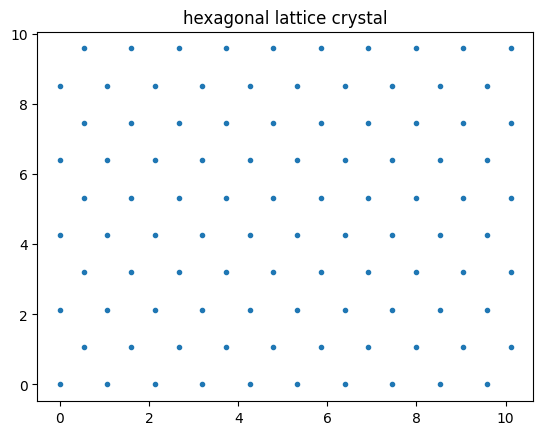

In [2]:
plt.plot(positions[:,0],positions[:,1],'.')
plt.title('hexagonal lattice crystal')

In [3]:
np.mean(velocities**2)

0.39785663648430136

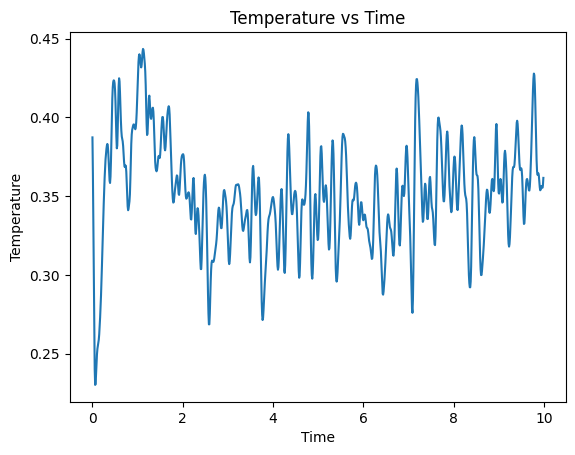

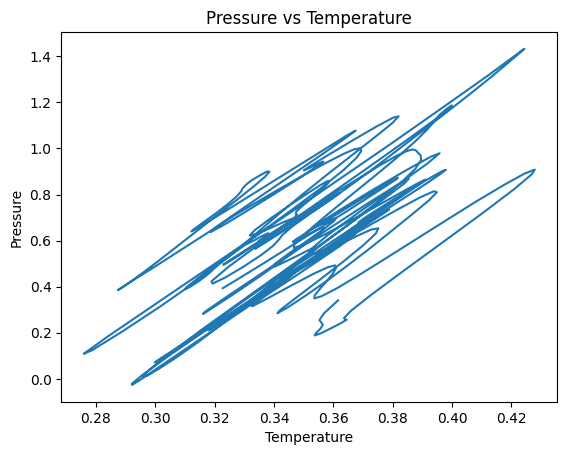

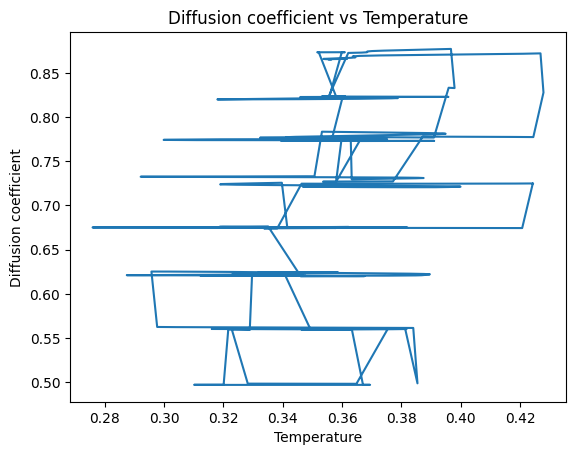

In [4]:
# Simulation
n_steps = 1000
temperatures = np.zeros(n_steps)
pressures = np.zeros(n_steps)
time = np.arange(n_steps) * dt
diffusion_coeff=np.zeros(n_steps)
positions_array = np.zeros(n_steps)

for step in range(n_steps):
    # Perform velocity Verlet step
    velocity_verlet_step()

    # Calculate temperature
    temperatures[step] = calculate_temperature()
    
    # (e) Calculate pressure
    forces,pressure = compute_forces()
    pressure+=np.sum(velocities**2)
    pressures[step] = pressure/L**2

    # Calculate diffusion coefficient
    displacement = positions - positions_ini
    diffusion_coeff[step] = np.mean(np.sum(displacement**2, axis=1)) / (2 * n_steps * dt)

# (d) Plot temperature
plt.figure()
plt.plot(time, temperatures)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature vs Time')
plt.show()

# (e) Plot pressure and diffusion coefficient
plt.figure()
plt.plot(temperatures[500:], pressures[500:])
plt.xlabel('Temperature')
plt.ylabel('Pressure')
plt.title('Pressure vs Temperature')
plt.show()

plt.figure()
plt.plot(temperatures[500:], diffusion_coeff[500:])
plt.xlabel('Temperature')
plt.ylabel('Diffusion coefficient')
plt.title('Diffusion coefficient vs Temperature')
plt.show()

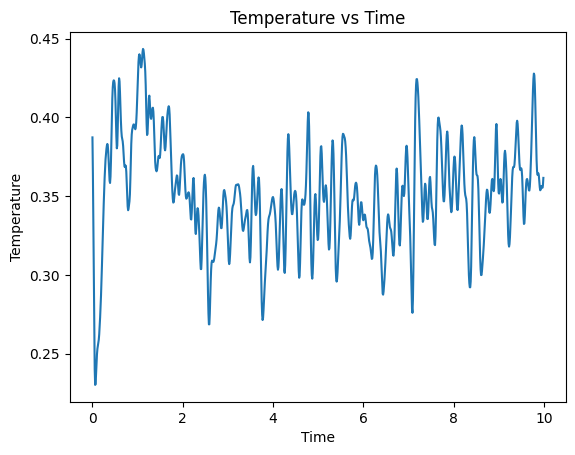

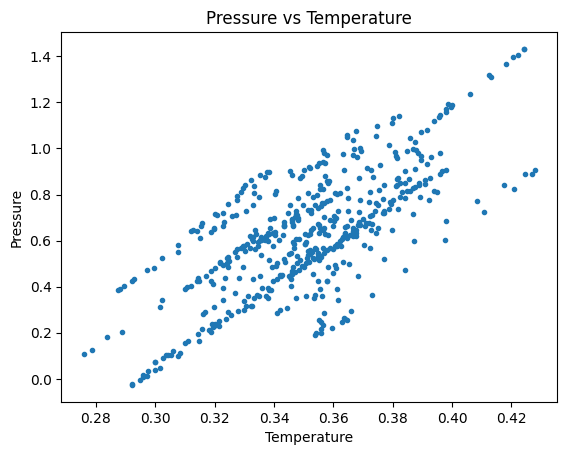

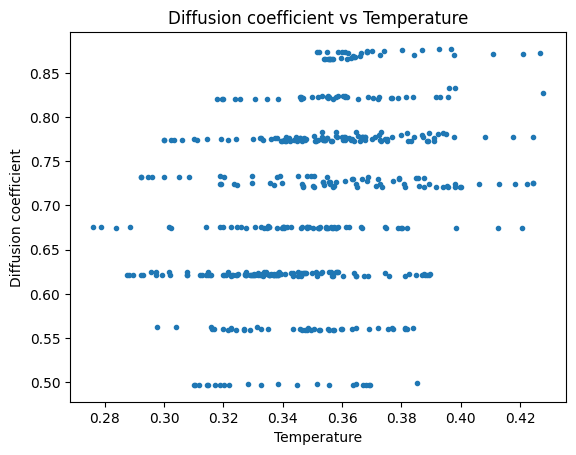

In [5]:
# (d) Plot temperature
plt.figure()
plt.plot(time, temperatures)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature vs Time')
plt.show()

# (e) Plot pressure and diffusion coefficient
plt.figure()
plt.plot(temperatures[500:], pressures[500:],'.')
plt.xlabel('Temperature')
plt.ylabel('Pressure')
plt.title('Pressure vs Temperature')
plt.show()

plt.figure()
plt.plot(temperatures[500:], diffusion_coeff[500:],'.')
plt.xlabel('Temperature')
plt.ylabel('Diffusion coefficient')
plt.title('Diffusion coefficient vs Temperature')
plt.show()

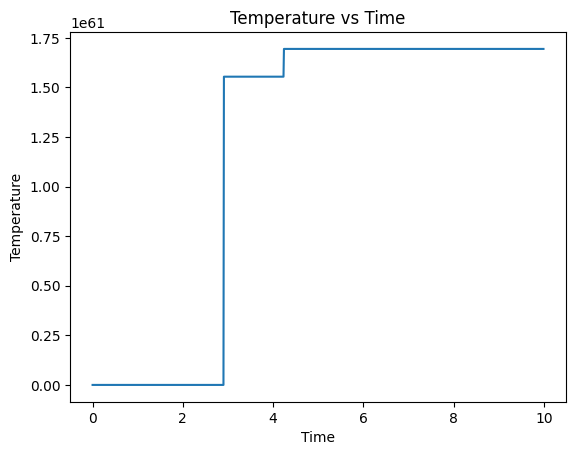

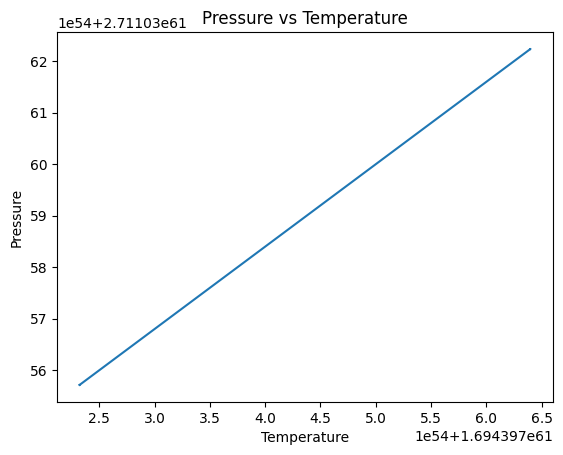

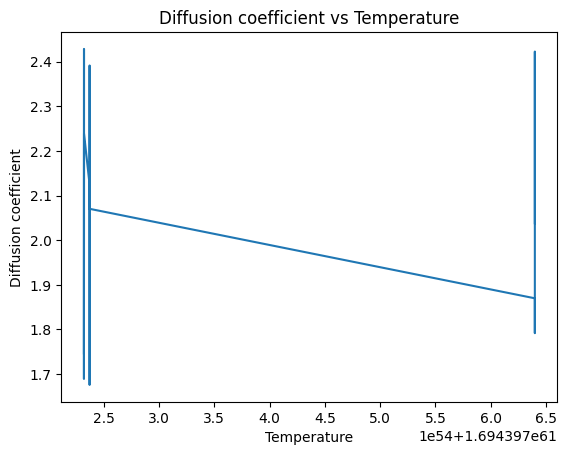

In [6]:
# Simulation
n_steps = 1000

temperatures_euler = np.zeros(n_steps) 
pressures_euler = np.zeros(n_steps)
time = np.arange(n_steps) * dt
diffusion_coeff_euler=np.zeros(n_steps)

positions = np.copy(positions_ini)
T = 0.4  # Temperature
velocities = np.random.randn(N, 2) * np.sqrt(T)
forces = np.zeros((N, 2))  # Particle forces
for step in range(n_steps):
    # Perform velocity Verlet step
    Euler_step()

    # Calculate temperature
    temperatures_euler[step] = calculate_temperature()
    # (e) Calculate pressure
    forces,pressure = compute_forces()
    pressure+=np.sum(velocities**2)
    pressures_euler[step] = pressure/L**2

    # Calculate diffusion coefficient
    displacement = positions - positions_ini
    diffusion_coeff_euler[step] = np.mean(np.sum(displacement**2, axis=1)) / (2 * n_steps * dt)

# (d) Plot temperature
plt.figure()
plt.plot(time, temperatures_euler)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature vs Time')
plt.show()

# (e) Plot pressure and diffusion coefficient
plt.figure()
plt.plot(temperatures_euler[500:], pressures_euler[500:])
plt.xlabel('Temperature')
plt.ylabel('Pressure')
plt.title('Pressure vs Temperature')
plt.show()

plt.figure()
plt.plot(temperatures_euler[500:], diffusion_coeff_euler[500:])
plt.xlabel('Temperature')
plt.ylabel('Diffusion coefficient')
plt.title('Diffusion coefficient vs Temperature')
plt.show()

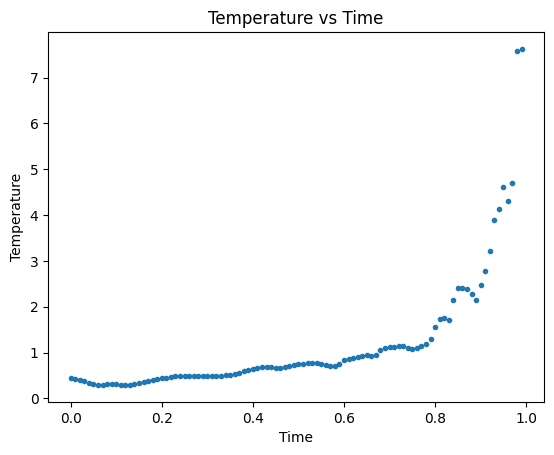

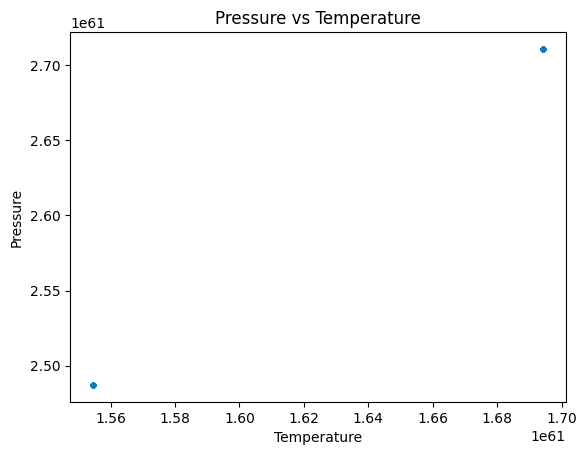

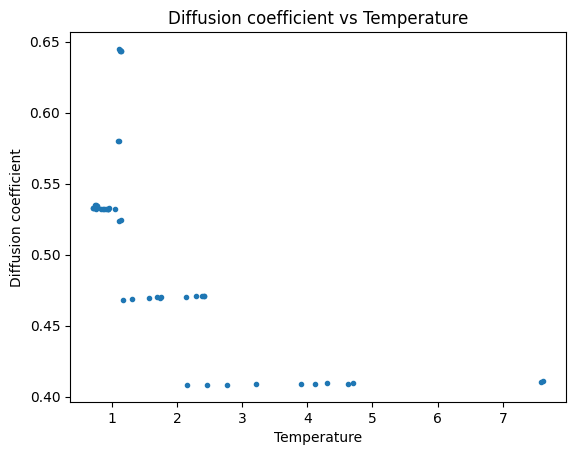

In [7]:
# (d) Plot temperature
plt.figure()
plt.plot(time[:100], temperatures_euler[:100],'.')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature vs Time')
plt.show()

# (e) Plot pressure and diffusion coefficient
plt.figure()
plt.plot(temperatures_euler[400:500], pressures_euler[400:500],'.')
plt.xlabel('Temperature')
plt.ylabel('Pressure')
plt.title('Pressure vs Temperature')
plt.show()

plt.figure()
plt.plot(temperatures_euler[50:100], diffusion_coeff_euler[50:100],'.')
plt.xlabel('Temperature')
plt.ylabel('Diffusion coefficient')
plt.title('Diffusion coefficient vs Temperature')
plt.show()

Text(0.5, 1.0, 'hexagonal lattice crystal')

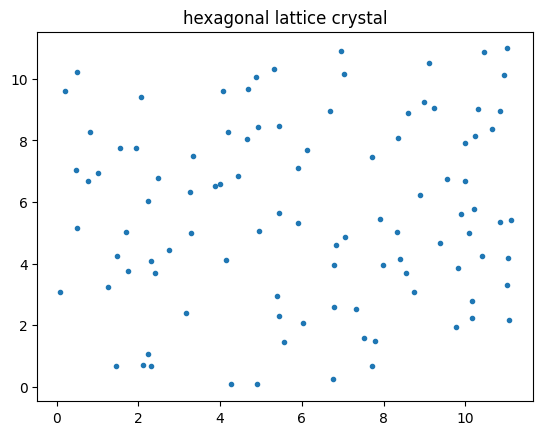

In [8]:
plt.plot(positions[:,0],positions[:,1],'.')
plt.title('hexagonal lattice crystal')

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.optimize import curve_fit
import numpy as np

# Constants
N = 100  # Number of particles
L = np.sqrt(N / 0.8)  # Box length
rc = 2.5  # Cutoff radius
dt = 0.001  # Time step

# Initialization
def initialization():
    global positions,velocities,forces
    positions = np.zeros((N, 2))  # Particle positions
    velocities = np.zeros((N, 2))  # Particle velocities
    forces = np.zeros((N, 2))  # Particle forces

    # (a) Construct hexagonal crystal
    nx = int(np.sqrt(N))
    ny = int(N / nx)
    delta_x = L / (nx + 0.5)
    delta_y = L / (ny + 0.5)
    count = 0
    for i in range(nx):
        for j in range(ny):
            x = (i + 0.5 * (j % 2)) * delta_x  # Shift every other row
            y = j * delta_y
            positions[count, :] = [x, y]
            count += 1
    positions_ini = np.copy(positions)
    # (b) Assign random velocities from Maxwell-Boltzmann distribution
    T = 0.4  # Temperature
    velocities = np.random.randn(N, 2) * np.sqrt(T)

# Helper functions
def lj_force(sigma,r):
    """Lennard-Jones force between two particles."""
    sr6 = (sigma / r) ** 6
    sr12 = sr6 ** 2
    return 24 * (2 * sr12 - sr6) / r

def compute_forces(sigma):
    """Compute forces on particles."""
    forces = np.zeros((N, 2))
    pressure_x, pressure_y = 0,0
    for i in range(N):
        for j in range(i + 1, N):
            dx = positions[i, 0] - positions[j, 0]
            dy = positions[i, 1] - positions[j, 1]
            dx -= L * np.round(dx / L)  # Minimum image convention
            dy -= L * np.round(dy / L)  # Minimum image convention
            r = np.sqrt(dx**2 + dy**2)
            if r < rc:
                f = lj_force(sigma,r)
                pressure_x -= f * dx * dx / r
                pressure_y -= f * dy * dy / r
                forces[i, 0] += f * dx / r
                forces[i, 1] += f * dy / r
                forces[j, 0] -= f * dx / r
                forces[j, 1] -= f * dy / r
    pressure = (pressure_x+pressure_y)/2
    return forces,pressure


# (c) Velocity-Verlet integration
def velocity_verlet_step(sigma):
    global positions, velocities, forces
    forces,pressure = compute_forces(sigma)
    positions += velocities * dt + 0.5 * forces * dt**2
    positions = np.mod(positions, L)  # Apply periodic boundary conditions
    forces_new,pressure = compute_forces(sigma)
    velocities += 0.5 * (forces + forces_new) * dt

def Euler_step(sigma):
    global positions, velocities, forces
    forces,pressure = compute_forces(sigma)
    positions += velocities * dt + 0.5 * forces * dt**2
    positions = np.mod(positions, L)  # Apply periodic boundary conditions
    velocities +=  forces * dt
    
# (d) Calculate temperature
def calculate_temperature():
    return np.mean(np.sum(velocities**2, axis=1)) / 2
 


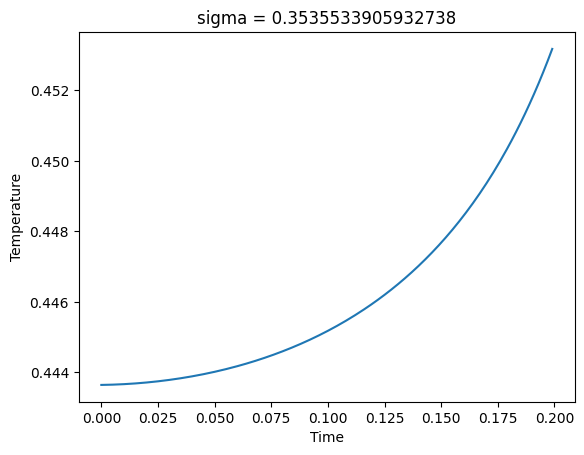

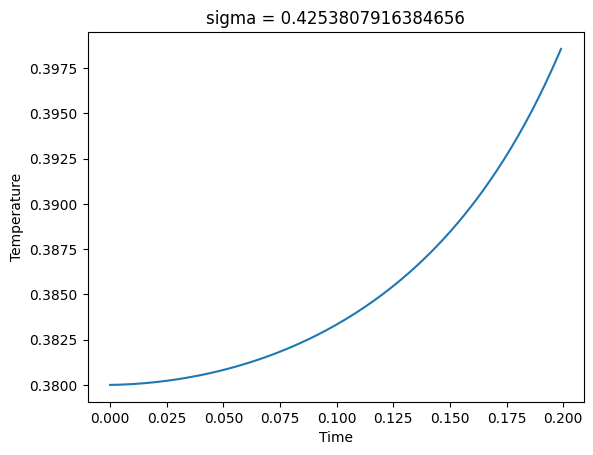

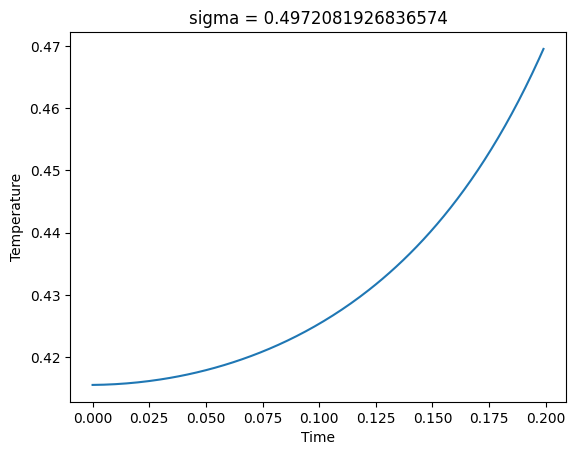

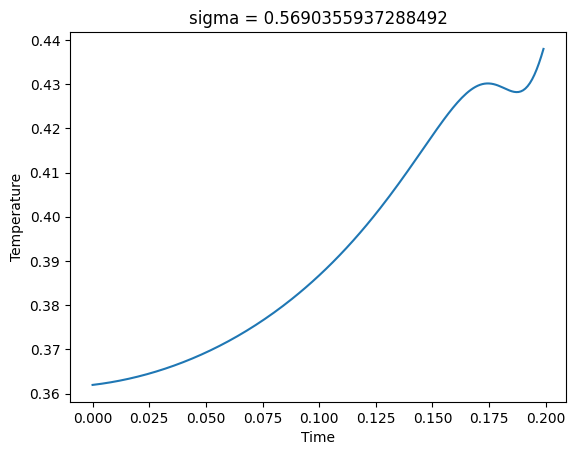

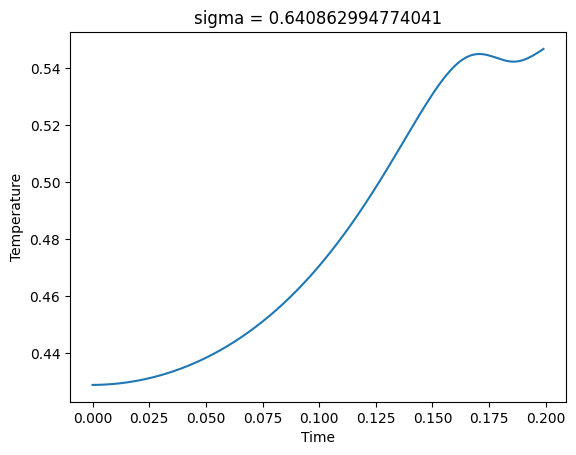

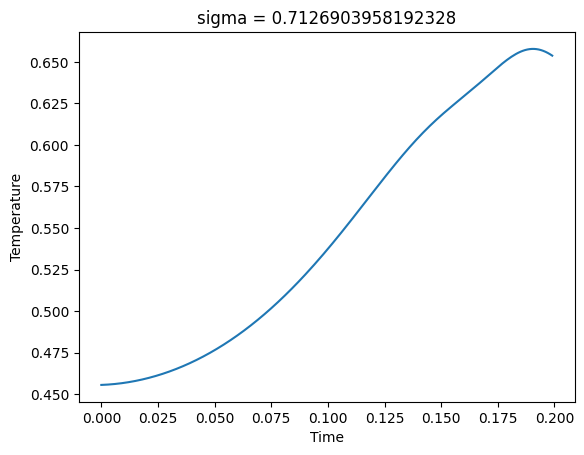

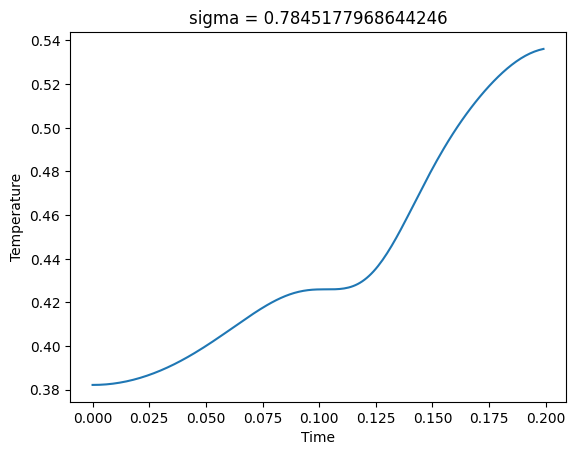

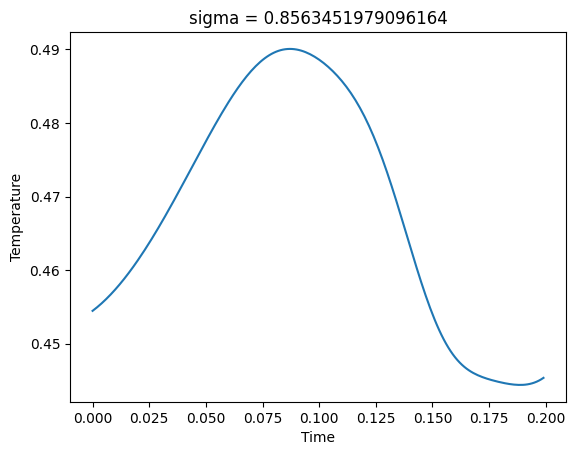

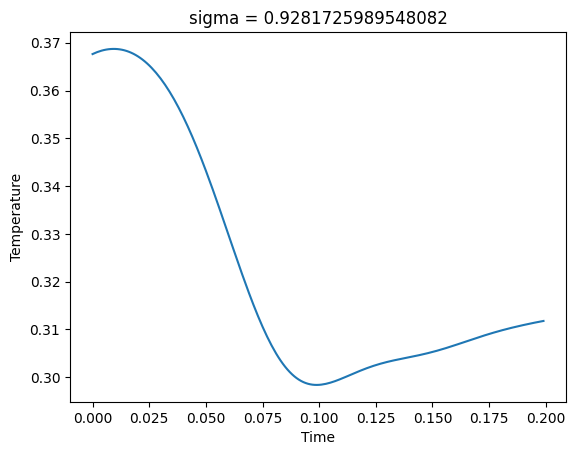

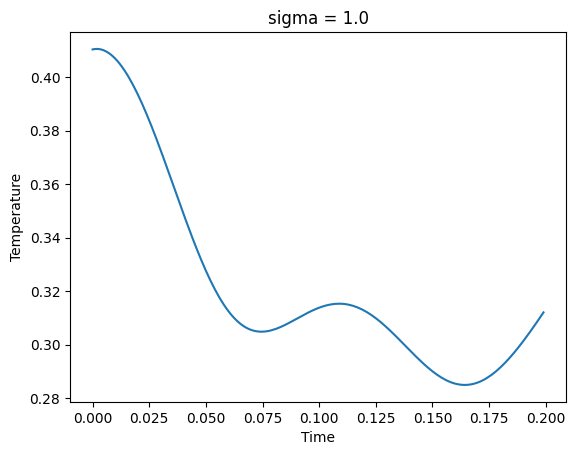

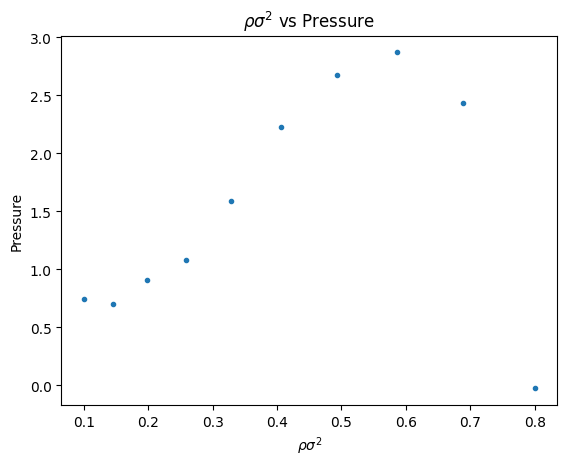

In [6]:

sigma_list = np.linspace(np.sqrt(1/8),1,10)
pressure_list = np.zeros(len(sigma_list))
index = 0
for sigma in sigma_list:
    # Simulation
    n_steps = 200
    temperatures = np.zeros(n_steps)
    pressures = np.zeros(n_steps)
    time = np.arange(n_steps) * dt
    diffusion_coeff=np.zeros(n_steps)
    positions_array = np.zeros(n_steps)
    initialization()
    
    for step in range(n_steps):
        # Perform velocity Verlet step
        velocity_verlet_step(sigma)

        # Calculate temperature
        temperatures[step] = calculate_temperature()
        
        # (e) Calculate pressure
        forces,pressure = compute_forces(sigma)
        pressure+=np.sum(velocities**2)
        pressures[step] = pressure/L**2

        # Calculate diffusion coefficient
        displacement = positions - positions_ini
        diffusion_coeff[step] = np.mean(np.sum(displacement**2, axis=1)) / (2 * n_steps * dt)
    pressure_list[index] = np.mean(pressures)
    index+=1
    # (d) Plot temperature
    plt.figure()
    plt.plot(time,temperatures)
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.title('sigma = '+str(sigma))
    plt.show()



plt.figure()
plt.plot(sigma_list**2*0.8, pressure_list,'.')
plt.xlabel(r'$\rho \sigma^2$')
plt.ylabel('Pressure')
plt.title(r'$\rho \sigma^2$ vs Pressure')
plt.show()

In [11]:
sigma_list**2

array([0.125     , 0.18094882, 0.24721599, 0.32380151, 0.41070538,
       0.5079276 , 0.61546817, 0.7333271 , 0.86150437, 1.        ])

In [17]:
pressure_list

array([0.81908304, 1.04243849, 1.30551503, 1.29369645, 1.4099025 ,
       1.4999916 , 1.35208506, 1.20383334, 1.13724038, 0.56143954])